# Quantile LOWESS for Data Cleaning

In this notebook we'll look at how we can use our LOWESS methods to process wind turbine SCADA data and fit a clean power curve that doesn't include under-powered periods.

<br>

### Imports

In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from moepy import lowess, eda

<br>

### Loading Data

We'll start by loading the SCADA data in

In [14]:
df_SCADA = pd.read_csv('../data/lowess_examples/turbine_SCADA.csv')

df_SCADA.head(3)

,UTC,T01_active_power,T01_blade_pitch,T01_generator_speed,T01_wind_speed,T02_active_power,T02_blade_pitch,T02_generator_speed,T02_wind_speed,T03_active_power,...,T09_theoretical_power,T10_theoretical_power,T11_theoretical_power,T12_theoretical_power,T13_theoretical_power,T14_theoretical_power,T15_theoretical_power,T16_theoretical_power,pc_error,wind_angle_rad
0,2017-09-30 18:26:40,56.0,-0.4,573.0,4.51,-4.0,5.2,682.0,2.21,-41.0,...,163.0,0.0,23.32,101.26,121.42,32.33,54.88,93.42,838.636286,NaN
1,2017-09-30 18:56:40,56.0,-0.4,573.0,4.51,-4.0,5.2,682.0,2.21,-41.0,...,163.0,0.0,23.32,101.26,121.42,32.33,54.88,93.42,838.636286,NaN
2,2017-09-30 19:26:40,56.0,-0.4,573.0,4.51,-4.0,5.2,682.0,2.21,-41.0,...,163.0,0.0,23.32,101.26,121.42,32.33,54.88,93.42,838.636286,NaN


<br>

We'll extract data for a single turbine

In [15]:
filter_for_turbine = lambda df, turbine=1: df[['UTC', f'T{str(turbine).zfill(2)}_active_power', f'T{str(turbine).zfill(2)}_wind_speed', 'wind_angle_rad']].pipe(lambda df: df.rename(columns=dict(zip(df.columns, df.columns.str.replace(f'T{str(turbine).zfill(2)}_', '')))))

df_turbine = filter_for_turbine(df_SCADA, 15).dropna()

df_turbine.head()

,UTC,active_power,wind_speed,wind_angle_rad
12,2017-10-01 00:26:40,68.0,4.396667,-1.035572
13,2017-10-01 00:56:40,112.5,3.690000,-0.969684
14,2017-10-01 01:26:40,238.0,4.670000,0.395575
15,2017-10-01 01:56:40,494.0,7.140000,-1.460979
16,2017-10-01 02:26:40,562.0,5.370000,0.493009


<br>

### Power Curve Cleaning

We'll then try and fit a Lowess estimate for the power curve.

c:\users\ayrto\desktop\phd\analysis\merit-order-effect\moepy\lowess.py:145: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas = np.linalg.lstsq(A, b)[0]


Wall time: 585 ms


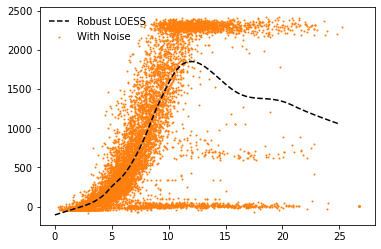

In [16]:
%%time

x = df_turbine['wind_speed'].values
y = df_turbine['active_power'].values

lowess_model = lowess.Lowess()
lowess_model.fit(x, y, frac=0.2, num_fits=100)

x_pred = np.linspace(0, 25, 101)
y_pred = lowess_model.predict(x_pred)

# Plotting
plt.plot(x_pred, y_pred, '--', label='Robust LOESS', color='k', zorder=3)
plt.scatter(x, y, label='With Noise', color='C1', s=1, zorder=1)
plt.legend(frameon=False)

<br>

Unfortunately the fit is thrown by the large number of occurences where the farm is under-powered or set to output 0, we want to remove these so that we can estimate the 'standard' power curve. We'll create a quantile Lowess fit to see if that helps us understand the data any better.

In [17]:
# Estimating the quantiles
df_quantiles = lowess.quantile_model(x, y, frac=0.2, qs=np.linspace(0.025, 0.975, 41), num_fits=40)

# Cleaning names and sorting for plotting
df_quantiles.columns = [f'p{int(col*100)}' for col in df_quantiles.columns]
df_quantiles = df_quantiles[df_quantiles.columns[::-1]]

df_quantiles.head()

 [████████████████████████████████████████████████████████████] 41/41 [02:08<00:03, 3.12s/it]

,p97,p95,p92,p90,p88,p85,p83,p80,p78,p76,...,p23,p21,p19,p16,p14,p12,p9,p7,p4,p2
x,,,,,,,,,,,,,,,,,,,,,
0.25,-31.860696,-36.669048,-49.591663,-50.801088,-54.897896,-62.434574,-65.669749,-68.233124,-68.978879,-69.727429,...,-79.596249,-74.346266,-69.082512,-62.705295,-58.361960,-53.923307,-50.093880,-49.133993,-50.204981,-51.814971
0.33,-25.204007,-31.291942,-44.473507,-46.183799,-50.499260,-58.150837,-61.482390,-64.178519,-65.075525,-65.957103,...,-78.243608,-73.379886,-68.427162,-62.365775,-58.143574,-53.878093,-50.080810,-49.060602,-49.981424,-51.572415
0.41,-18.657741,-25.989947,-39.441039,-41.631715,-46.156123,-53.916891,-57.338453,-60.163005,-61.208625,-62.225847,...,-76.897035,-72.414257,-67.779658,-62.049403,-57.951227,-53.851247,-50.079145,-49.001349,-49.757637,-51.331687
0.49,-12.175776,-20.724678,-34.459209,-37.113204,-41.840145,-49.706321,-53.214941,-56.164650,-57.357093,-58.512929,...,-75.543285,-71.435088,-67.123936,-61.737423,-57.768214,-53.828890,-50.079421,-48.949263,-49.532682,-51.092106
0.57,-5.711144,-15.457152,-29.492201,-32.596020,-37.522486,-45.492376,-49.088458,-52.161221,-53.499585,-54.797276,...,-74.169096,-70.428227,-66.444072,-61.411097,-57.577766,-53.797131,-50.072217,-48.897306,-49.305623,-50.852972


<br>

Plotting these we can see an interesting relationship, where for many of the lower quantiles the estimate peaks then quickly drops to around 0. It is the area below and to the right of these peaks that we want to remove from our power curve estimate.

(0.0, 2715.0737814101485)

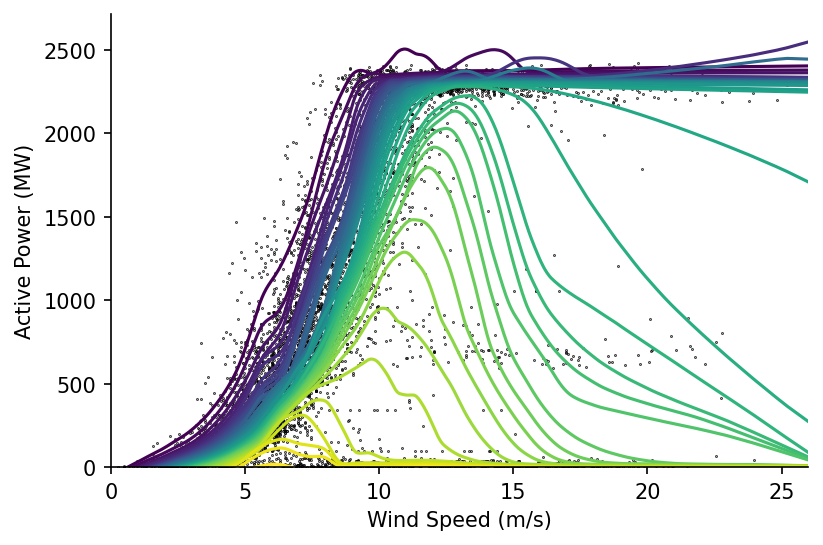

In [18]:
fig, ax = plt.subplots(dpi=150)

ax.scatter(x, y, s=0.1, color='k', alpha=1)
df_quantiles.plot(cmap='viridis', legend=False, ax=ax)

eda.hide_spines(ax)
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Active Power (MW)')
ax.set_xlim(0, 26)
ax.set_ylim(0)

<br>

We'll first identify the ratio between the peak value and the final value (above speeds of 25 m/s). We'll then remove points after the peak where the ratio between their peak and final values exceeds a defined threshold (in our case 2).

N.b. there's probably a much nicer way to do this where the for loop isn't needed, this would be handy to implement as it would be good to have a vector containing all of the indexes that have been removed.

In [19]:
exceeded_quantiles = ((df_quantiles.max()/df_quantiles.iloc[-1].clip(0.1) > 2)
                      .replace(False, np.nan)
                      .dropna()
                      .index
                     )

s_maxs = df_quantiles[exceeded_quantiles].max()
s_idxmaxs = df_quantiles[exceeded_quantiles].idxmax()

cleaned_x = x
cleaned_y = y

for exceeded_quantile in exceeded_quantiles:
    min_x = s_idxmaxs[exceeded_quantile]
    max_y = s_maxs[exceeded_quantile]
    
    idxs_to_remove = (cleaned_x > min_x) & (cleaned_y < max_y)

    cleaned_x = cleaned_x[~idxs_to_remove]
    cleaned_y = cleaned_y[~idxs_to_remove]

<br>

Visualising the results we can clearly see that the unwanted periods have been removed

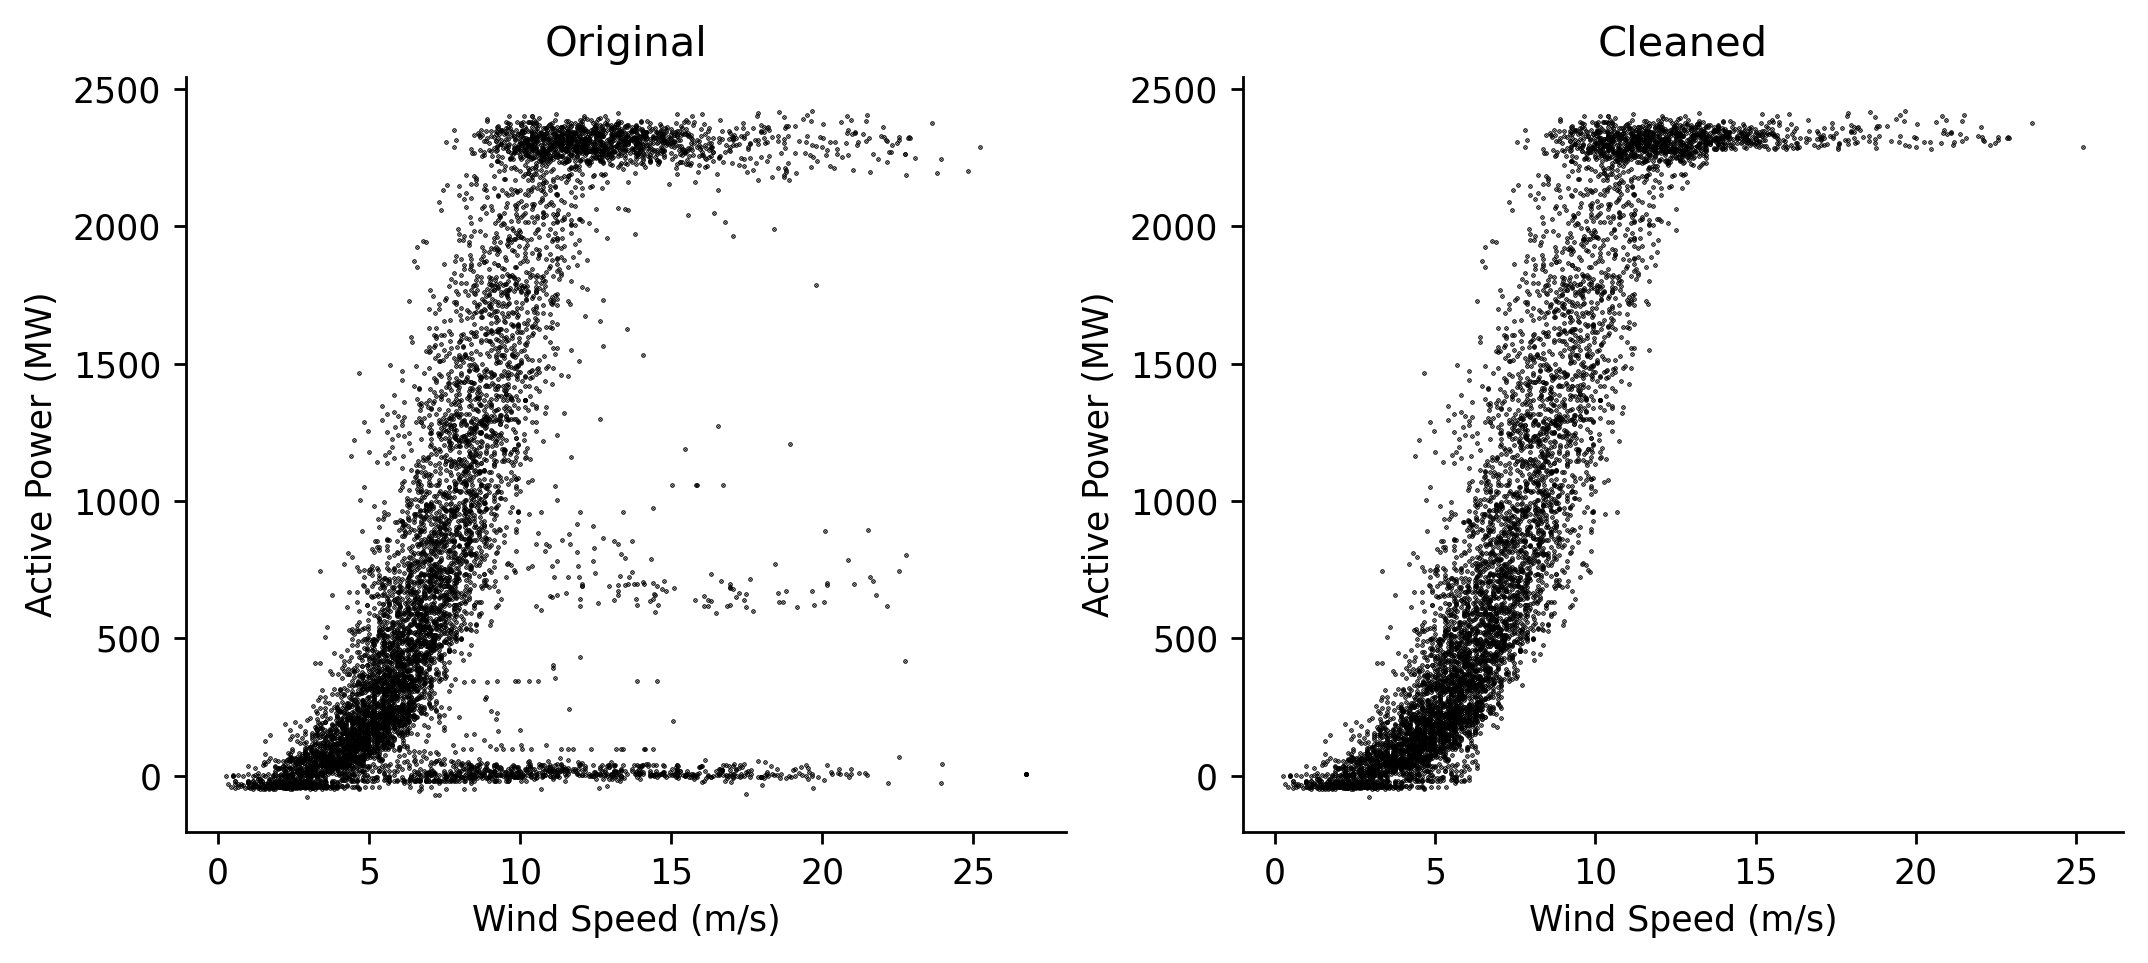

In [20]:
fig, axs = plt.subplots(dpi=250, ncols=2, figsize=(10, 4))

axs[0].scatter(x, y, s=0.1, color='k', alpha=1)
axs[1].scatter(cleaned_x, cleaned_y, s=0.1, color='k', alpha=1)

axs[0].set_title('Original')
axs[1].set_title('Cleaned')

for ax in axs:
    eda.hide_spines(ax)
    ax.set_xlabel('Wind Speed (m/s)')
    ax.set_ylabel('Active Power (MW)')

<br>

We're now ready to make our power curve lowess estimate again

c:\users\ayrto\desktop\phd\analysis\merit-order-effect\moepy\lowess.py:145: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas = np.linalg.lstsq(A, b)[0]


Wall time: 550 ms


Text(0, 0.5, 'Active Power (MW)')

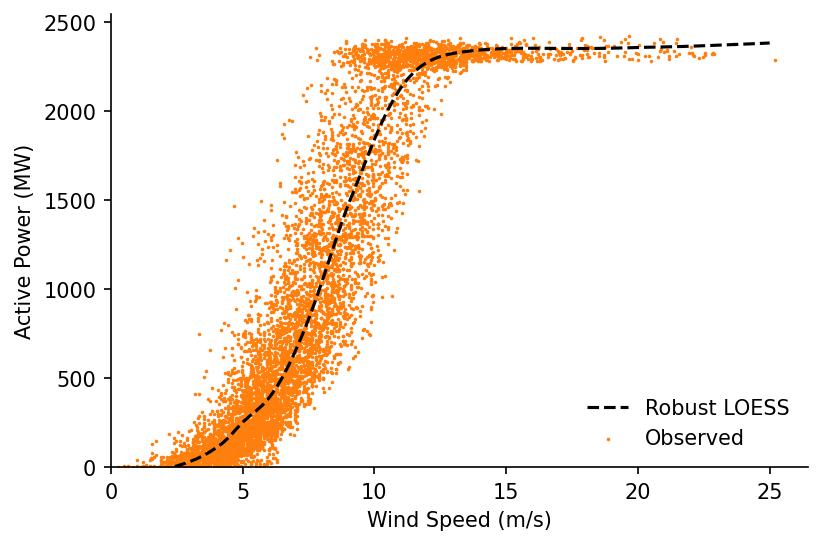

In [22]:
%%time

lowess_model = lowess.Lowess()
lowess_model.fit(cleaned_x, cleaned_y, frac=0.2, num_fits=100)

x_pred = np.linspace(0, 25, 101)
y_pred = lowess_model.predict(x_pred)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.plot(x_pred, y_pred, '--', label='Robust LOESS', color='k', zorder=3)
ax.scatter(cleaned_x, cleaned_y, label='Observed', color='C1', s=0.5, zorder=1)

ax.legend(frameon=False)
eda.hide_spines(ax)
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Active Power (MW)')

<br>

Potential areas for future exploration:
* Clip y to something like 0.01, just needs to be marginally above 0
* Should check what happens to the lower part though, because of frac the neg values may be helping
* What happens if I fit for data where power<2250 and speed<14
* Could then have a seperate distribution fit for the period after
* Could then use weights to transition between them
* Inspecting the active power spikes for the removed values should identify set-points